In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shapely as shp
import geopandas as gpd
import math
import random
import scipy.stats as stats
import xarray as xr

In [2]:
'''Functions'''
def rotate_origin_only(x, y, radians):
    """Only rotate a point around the origin (0, 0)."""
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [3]:
random.seed(12345)

## Testing

In [4]:
#Declare some points
site = shp.Point((0, 0)).buffer(8)
p1 = shp.Point((-1.3, 1.7)).buffer(3) #tree 1
p2 = shp.Point((1.5, -0.25)).buffer(1.3) #tree 2
p3 = shp.Point((-3.2, -5.5)).buffer(2.5) #tree 3

In [5]:
#See how far they are from the center of the plot
print(p1.centroid.distance(shp.Point(0,0)))
print(p2.centroid.distance(shp.Point(0,0)))
print(p3.centroid.distance(shp.Point(0,0)))

2.1400934559032705
1.5206906325745548
6.363175307973212


(-8.0, 8.0)

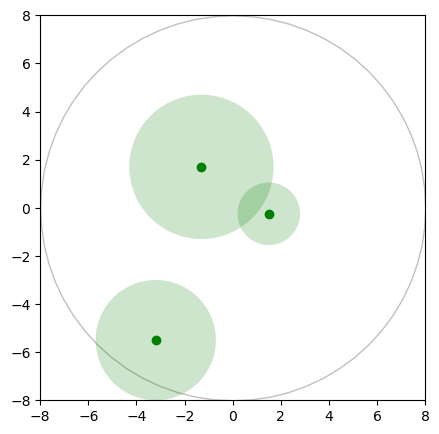

In [6]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for p in [p1, p2, p3]:
    gpd.GeoSeries(p).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(p.centroid).plot(ax = ax, color = 'green')

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [7]:
#Try Generating random trees with a specific mean distance and sd
#Generate distances
dists = np.random.normal(loc = 4.2, scale = 2.1, size = 10)

#Check all are in correct range
while(dists > 8).any():
    dists = np.random.normal(loc = 4.2, scale = 2.1, size = 10)

#Generate DBHs (in cm)
dbhs = np.random.normal(loc = 32, scale = 3.4, size = 10)

#calculate crown diameter (using allometric equation for American Elm)
crown = (1.92 + 18.30*(dbhs/100))/2

#Generate locations
trees = []
start = site.centroid
for i in range(0, len(dists)):
    #assume on x axis and rotate a random number of degrees
    deg = np.random.uniform(low = 0, high = 2*math.pi)
    xx, yy = rotate_origin_only(dists[i], 0, deg)

    #create point
    trees.append(shp.Point((xx, yy)).buffer(crown[i]))
   
    

(-8.0, 8.0)

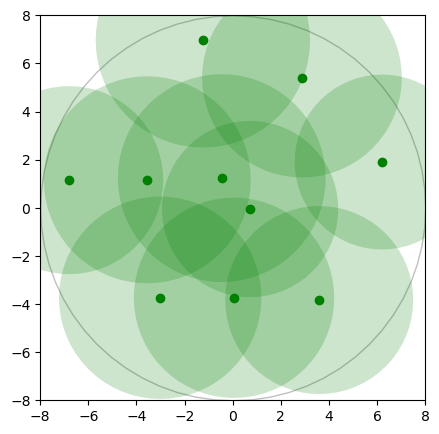

In [8]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for tree in trees:
    gpd.GeoSeries(tree).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(tree.centroid).plot(ax = ax, color = 'green')

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [9]:
'''Calculate total overlap coverage'''
#Use shapely to calculate the total union and the intersection over the union
uni = shp.ops.unary_union(trees)

(-8.0, 8.0)

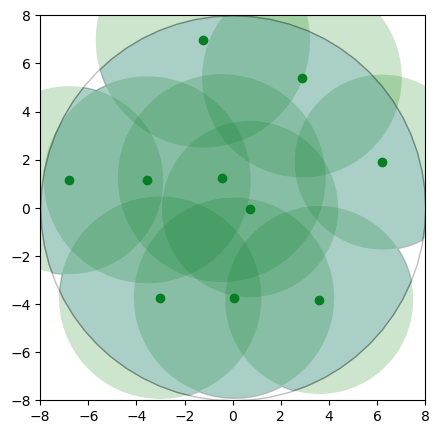

In [10]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for tree in trees:
    gpd.GeoSeries(tree).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(tree.centroid).plot(ax = ax, color = 'green')

#clip and plot union
uni_clipped = gpd.GeoSeries(uni).clip(site)
gpd.GeoSeries(uni_clipped).plot(ax = ax, edgecolor = 'black', alpha = 0.2)

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [11]:
#Calculate percent of site covered by tree
pcoverage = uni_clipped.area/site.area
pcoverage

0    0.990211
dtype: float64

In [12]:
'''Calculate total overlap'''

#Collect intersections recursively
temp = trees[0]
intersects = []
for tree in trees[1:]:
    #add intersection of unioned shape and new tree
    intersects.append(shp.intersection(tree, temp))
    #compute union
    temp = shp.union(tree, temp)

intersect = shp.ops.unary_union(intersects)

(-8.0, 8.0)

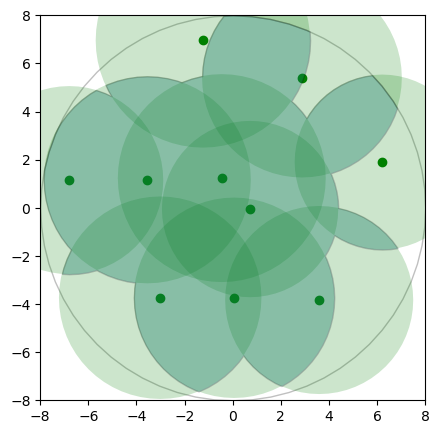

In [13]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for tree in trees:
    gpd.GeoSeries(tree).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(tree.centroid).plot(ax = ax, color = 'green')

#clip and plot union
int_clipped = gpd.GeoSeries(intersect).clip(site)
gpd.GeoSeries(int_clipped).plot(ax = ax, edgecolor = 'black', alpha = 0.2)

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [14]:
#Calculate percent of site overlapped
poverlap = int_clipped.area/site.area
poverlap

0    0.713296
dtype: float64

## Function

In [44]:
'''Combine into function'''

def simulateSite(n, distMu, distSigma, dbhMu, dbhSigma, pCon, plots = False):
    #Step 1: Generate site
    site = shp.Point((0, 0)).buffer(8)

    #Generate distances
    dists = np.random.normal(loc = distMu, scale = distSigma, size = n)

    #Check all are in correct range
    while ((dists > 8).any()) | ((dists < 0).any()):
        dists = np.random.normal(loc = distMu, scale = distSigma, size = n)

    #Generate DBHs (in cm)
    dbhs = np.random.normal(loc = dbhMu, scale = dbhSigma, size = n)

    #Check all are in correct range
    while(dbhs < 0).any():
        dbhs = np.random.normal(loc = dbhMu, scale = dbhSigma, size = n)

    #Generate conif crown widths 
    conifCC = (stats.gamma.rvs(2.84604046158689, loc=-1.8990921243783796, scale=14.411867120014431, size=n))/100
    while(conifCC < 0).any():
        conifCC = (stats.gamma.rvs(2.84604046158689, loc=-1.8990921243783796, scale=14.411867120014431, size=n))/100

    #Based on pCon, assign crown width for conif and decid trees
    nCon = int(n*pCon)
    crown = np.zeros(n)
    #take first nCon trees:
    if nCon == n:
        #For sites with all conifers, just take all simulated crown data
        crown = conifCC
    elif (nCon > 0) & (nCon < n):
        #CONIFEROUS - take first nCon values
        crown[0:nCon+1] = conifCC[0:nCon+1]
        #DECIDUOUS - calculate crown diameter (using allometric equation for american elm)
        crown[nCon+1:] = (1.92 + 18.30*(dbhs[nCon+1:]/100))/2
    else:
        #try just using DBH instead of overestimated canopy 
        crown = (1.92 + 18.30*(dbhs/100))/2

    #Generate locations
    trees = []
    start = site.centroid
    for i in range(0, len(dists)):
        #assume on x axis and rotate a random number of degrees
        deg = np.random.uniform(low = 0, high = 2*math.pi)
        xx, yy = rotate_origin_only(dists[i], 0, deg)

        #create point
        trees.append(shp.Point((xx, yy)).buffer(crown[i]))


    #Step 1.5: Calculate total tree canopy
    areas = [tree.area for tree in trees]
    tot = np.cumsum(areas)[-1]

    #Step 2: Calculate total plot coverage
    #Use shapely to calculate the total union and the intersection over the union
    uni = shp.ops.unary_union(trees)
    uni_clipped = gpd.GeoSeries(uni).clip(site)
    pcoverage = float(uni_clipped.area/site.area)

    #Step 3: Calculate total overlap
    #Collect intersections recursively
    temp = trees[0]
    intersects = []
    for tree in trees[1:]:
        #add intersection of unioned shape and new tree
        intersects.append(shp.intersection(tree, temp))
        #compute union
        temp = shp.union(tree, temp)

    #Merge
    intersect = shp.ops.unary_union(intersects)
    int_clipped = gpd.GeoSeries(intersect).clip(site)
    
    if(len(int_clipped.area) > 0):
        poverlap = float(int_clipped.area/site.area)
    else:
        poverlap = 0

    #Step 4: Plot
    if(plots):
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (5,  10), 
                                            sharex = True, 
                                            sharey = True, 
                                            layout = 'tight')

        #Plot union
        gpd.GeoSeries(site).plot(ax = ax1, edgecolor = 'silver', facecolor = 'white')
        for tree in trees:
            gpd.GeoSeries(tree).plot(ax = ax1, color = 'green', alpha = 0.2)
            gpd.GeoSeries(tree.centroid).plot(ax = ax1, color = 'green')
        gpd.GeoSeries(uni_clipped).plot(ax = ax1, edgecolor = 'black', alpha = 0.2)

        #Plot intersection
        gpd.GeoSeries(site).plot(ax = ax2, edgecolor = 'silver', facecolor = 'white')
        for tree in trees:
            gpd.GeoSeries(tree).plot(ax = ax2, color = 'green', alpha = 0.2)
            gpd.GeoSeries(tree.centroid).plot(ax = ax2, color = 'green')

        #clip and plot union
        gpd.GeoSeries(int_clipped).plot(ax = ax2, edgecolor = 'black', alpha = 0.2)

        ax1.set_xlim(-8, 8)
        ax1.set_ylim(-8, 8)
        ax1.set_title('Total Plot Coverage: ' + str(np.round(pcoverage, 2)), loc = 'left', size = 'small')
        ax2.set_xlim(-8, 8)
        ax2.set_ylim(-8, 8)
        ax2.set_title('Total Plot Overlap: ' + str(np.round(poverlap, 2)), loc = 'left', size = 'small')

    return pcoverage, poverlap, tot

(0.8108813372962177, 0.4054227166736025, 309.4975374274961)

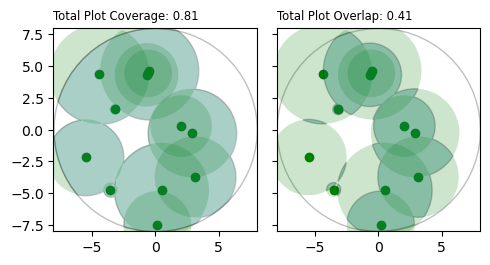

In [45]:
simulateSite(12, 4.2, 1.4, 22.8, 10.5, 0.11, plots = True)

## Concatenate LAI, Snow, and vegetation data

In [30]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset('./data/01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset('./data/01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

### Import forestry Data -- summarized by stake
forestInv = pd.read_csv('./data/vegdata_withsnow.csv')

In [31]:
forestInv.columns

Index(['Stake_ID', 'X', 'Zone', 'X..Sky.Area', 'X..Mask.Area', 'X..Cnpy.Open',
       'X..Site.Open', 'LAI.4Ring', 'LAI.5Ring', 'Watershed',
       'OLS.Prediction.Ring.4', 'WLS.Prediction.Ring.4',
       'OLS.Prediction.Ring.5', 'WLS.Prediction.Ring.5', 'Summer.LAI.4Ring',
       'Summer.LAI.5Ring', 'DIST_FT', 'DIST_M', 'DBH_IN', 'DBH_CM',
       'DIST_FT_SD', 'DIST_M_SD', 'DBH_IN_SD', 'DBH_CM_SD', 'n',
       'basalArea_m2', 'BIOMASS', 'Co', 'Dom', 'Int', 'Sup', 'prop_Deciduous',
       'prop_Coniferous', 'WATERSHED', 'avg_depths', 'max_depths'],
      dtype='object')

In [32]:
#Select necessary forest data
forest = forestInv[['Stake_ID', 'OLS.Prediction.Ring.5', 'DIST_FT', 'DIST_M', 'DBH_IN', 'DBH_CM',
       'DIST_FT_SD', 'DIST_M_SD', 'DBH_IN_SD', 'DBH_CM_SD', 'n', 'prop_Coniferous', 'Co']]

#Snow year
allSnow_df['SYear'] = [2024 if allSnow_df.time[i] > pd.to_datetime('09-01-2023') else 2023 for i in range(0, len(allSnow_df.time))]

#Remove Nan
allSnow_nan = allSnow_df.dropna().reset_index(drop = True)

#Take peak snow depth per site
peakSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].max().reset_index()
peakSnow = peakSnow.rename(columns = {'depths' : 'maxDepth'})

In [33]:
peakSnow

,stakes,northing,easting,zones,aspect,slope,watershed,SYear,maxDepth
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023,70.0
1,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2024,22.0
2,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023,59.0
3,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2024,18.0
4,S202,464819.0,5262344.0,Upland,352.4059,2.166370,S2,2023,33.0
...,...,...,...,...,...,...,...,...,...
103,S646,464582.2,5262240.0,Upland,166.1192,3.132299,S6,2024,20.0
104,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2023,57.0
105,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2024,17.0
106,S655,464644.0,5262449.0,Upland,259.7763,6.629145,S6,2023,60.0


In [34]:
#Merge with snow data
merged = pd.merge(peakSnow, forest, left_on = 'stakes', right_on = 'Stake_ID')
merged

,stakes,northing,easting,zones,aspect,slope,watershed,SYear,maxDepth,Stake_ID,...,DIST_M,DBH_IN,DBH_CM,DIST_FT_SD,DIST_M_SD,DBH_IN_SD,DBH_CM_SD,n,prop_Coniferous,Co
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023,70.0,S200,...,5.354320,8.261155,20.983333,4.232415,1.290040,3.001851,7.624701,12,0.000000,7
1,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2024,22.0,S200,...,5.354320,8.261155,20.983333,4.232415,1.290040,3.001851,7.624701,12,0.000000,7
2,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023,59.0,S201,...,4.480560,9.534121,24.216667,5.262967,1.604152,4.554940,11.569547,18,0.111111,9
3,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2024,18.0,S201,...,4.480560,9.534121,24.216667,5.262967,1.604152,4.554940,11.569547,18,0.111111,9
4,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023,49.0,S203,...,5.025390,5.725886,14.543750,6.042944,1.841889,1.568753,3.984632,16,0.437500,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,S646,464582.2,5262240.0,Upland,166.1192,3.132299,S6,2024,20.0,S646,...,4.842191,6.896922,17.518182,5.132963,1.564527,1.407426,3.574862,11,1.000000,10
96,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2023,57.0,S654,...,5.958172,6.962447,17.684615,5.905921,1.800125,2.433891,6.182083,26,0.000000,15
97,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2024,17.0,S654,...,5.958172,6.962447,17.684615,5.905921,1.800125,2.433891,6.182083,26,0.000000,15
98,S655,464644.0,5262449.0,Upland,259.7763,6.629145,S6,2023,60.0,S655,...,4.594945,6.303587,16.011111,5.932379,1.808189,2.537889,6.446238,18,0.444444,10


In [35]:
#Save to dataframe
merged.to_csv('./data/compiled_data_formodel.csv', index = False)